Stand: 24.02.25

## Ziel: Einflussmessung des Standortwechsels der Messstation DWD

- Messstation: 02712
    - ab dem 19.10.2020 wurde die Station von der Stadt ins Grüne verlegt
    - die Temperaturen sollten also ab 2021 geringer sein, was den Effekt des Klimawandels abmindern würde

- Vergleich mit einer anderen Wetterstation in der Nähe suchen 
    - https://www.meteoschweiz.admin.ch/service-und-publikationen/applikationen/messwerte-und-messnetze.html#param=messnetz-automatisch&table=false&station=HAI
    - mögliche Messtionen in der Nähe: Salen-Reutenen (HAI) und Güttingen (GUT)
    - Ab 1. April 2025 macht MeteoSchweiz ihre Daten für die Allgemeinheit zur freien Wiederverwendung als Open Government Data (OGD) verfügbar
    - Die Daten können als vorprozessierte Dateien heruntergeladen werden. In einer späteren Etappe werden auch individuelle Abfragen via API möglich
    - hier reinschauen, ob man doch was runterladen kann: https://github.com/MeteoSwiss/opendata/blob/main/README.md

- was ist der Unterschied zu MeteoSchweiz-Partnerstationen? Da gibt es auch Kreuzlingen:
    - https://www.meteoschweiz.admin.ch/service-und-publikationen/applikationen/messwerte-und-messnetze.html#param=messnetz-partner&table=false&station=TGKRE

-> **Zwischenstand:** aus der Schweiz können wir erstmal noch keine Daten nutzen - vllt eher nach nahen DWD Wetterstationen suchen :) 

## Infos zum Notebook:
Die Daten werden über eine API direkt vom DWD geladen und nur in den Arbeitsspeicher geladen. 
Historische und aktuelle Daten werden zusammengefügt und gesäubert. 

Man kann bei start_jahr und end_jahr verschiedene Jahre einstellen und das Notbook müsste sich anpassen. Die Farbpalette Viridis hat nur 11 Farben, deshalb kann gerade maximal ein Abstand von 10 Jahren eingestellt werden. 

In [1]:
import calendar
from bokeh.palettes import RdYlBu, Turbo256, Sunset, Spectral, Viridis
import pandas as pd
import numpy as np
from pathlib import Path
import locale
import seaborn as sns
import matplotlib.pyplot as plt

import zipfile
import requests # Meteorologie
from io import BytesIO # Meteorologie

locale.setlocale(locale.LC_ALL, 'deu_deu')

'German_Germany.1252'

Spaltenbedeutung: 
- RSK = tägliche Niederschlagshöhe [mm]
- TMK = Tagesmittel der Lufttemperatur in 2m Höhe [°C]
- SDK tägliche Sonnenscheindauer [h]
- FM Tagesmittel Windgeschwindigkeit [m/s]


In [2]:
station_id = "02712"
start_jahr = 2018
end_jahr = 2024
n_years = 1 + (end_jahr - start_jahr)
#[*Turbo256[0:n_years]]; [*RdYlBu[n_years]]
color_list = [*Viridis[n_years]]

url_akt = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/tageswerte_KL_{station_id}_akt.zip'
url_hist = f'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_{station_id}_19590701_20231231_hist.zip'

In [3]:
def get_meteo_data(url):
    # lädt ZIP-Datei von der URL
    dwd_zip = requests.get(url)
    # öffnet Zip-Datei im Speicher
    # BytesIO -> die im Speicher gespeicherten Bytes werden behandelt, als wären sie eine Datei
    archiv= zipfile.ZipFile(BytesIO(dwd_zip.content))
    # Liste aller Dateinamen in der ZIP-Datei
    filelist = archiv.namelist()
    filterlist= [x for x in filelist if 'produkt_klima_tag' in x]
    print(f"Gefundene Datei: {filterlist[0]}")
    # type: bytes -> sieht aus wie ein langer String, wo alles hintereinander geschrieben wurde mit ; und eor\r\n für neue Zeile
    csvdata = archiv.read(filterlist[0]) 
    data = pd.read_csv(BytesIO(csvdata), sep=';', encoding='utf-8').set_index('MESS_DATUM')
    data.columns = [name.strip() for name in data.columns] # Leerzeichen aus Spaltennamen entfernen
    return data

dwd_akt = get_meteo_data(url_akt)
dwd_hist = get_meteo_data(url_hist)

display(dwd_akt.head())
display(dwd_hist.head())

Gefundene Datei: produkt_klima_tag_20230830_20250301_02712.txt
Gefundene Datei: produkt_klima_tag_19590701_20231231_02712.txt


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
20230830,2712,10,6.5,1.6,9,1.3,6,5.9,0,6.0,12.9,960.9,14.9,77.0,20.4,11.4,10.8,eor
20230831,2712,10,8.0,2.8,9,0.2,6,1.8,0,7.9,13.0,965.2,15.7,74.0,18.5,13.1,12.1,eor
20230901,2712,10,9.4,1.8,9,0.0,0,9.6,0,5.4,14.8,967.1,19.0,69.0,25.3,13.8,12.8,eor
20230902,2712,10,4.9,1.4,9,0.0,0,12.4,0,5.3,15.8,970.4,19.4,73.0,27.6,12.2,11.3,eor
20230903,2712,10,5.9,1.6,9,0.0,0,10.2,0,6.8,16.9,975.2,20.0,74.0,26.8,13.1,12.0,eor


,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
MESS_DATUM,,,,,,,,,,,,,,,,,,
19590701,2712,5,11.8,4.3,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor
19590702,2712,5,8.8,3.7,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor
19590703,2712,5,14.2,2.3,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor
19590704,2712,5,5.2,1.8,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor
19590705,2712,5,4.4,1.0,-999,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,eor


### 2) Daten zusammenfügen und säubern

In [4]:


# DataFrames werden untereinander zusammengefügt; Index von beiden wird behalten
# durch keys wird ein Multiindex erzeugt, damit man sieht aus welcher Quelle die Daten komme
dwd = pd.concat([dwd_hist, dwd_akt], ignore_index=False, keys=['dwd_hist', 'dwd_akt'])
# Multiindices werden zu Spalten: level_0 und MESS_DATUM -> die Duplikate aus MESS_DATUM werden entfernt
# die Spalte mit den keys von davor, wird SOURCE genannt
dwd = dwd.reset_index().rename(columns={'level_0': 'SOURCE'}).drop_duplicates(subset='MESS_DATUM', keep='first')

# Datumsformat setzten
dwd['MESS_DATUM'] = pd.to_datetime(dwd['MESS_DATUM'], format='%Y%m%d')

dwd.replace(to_replace=-999, value = np.nan, inplace=True)

### 3) Monatlicher Niderschlag

In [5]:
dwd_RSK = dwd[["MESS_DATUM", "RSK"]].set_index("MESS_DATUM")[str(start_jahr):str(end_jahr)].resample("ME").sum().round(0)
dwd_RSK.index = dwd_RSK.index.to_period('M') # ansonsten steht da immer der letzte Tag des Monats
dwd_RSK["Monat"] = dwd_RSK.index.month
dwd_RSK["Monat2"] = dwd_RSK.index.strftime("%b.")
dwd_RSK["Monat3"] = dwd_RSK.index.strftime("%b. %y")
dwd_RSK["Jahr"] = dwd_RSK.index.year

dwd_RSK

,RSK,Monat,Monat2,Monat3,Jahr
MESS_DATUM,,,,,
2018-01,104.0,1,Jan.,Jan. 18,2018
2018-02,45.0,2,Feb.,Feb. 18,2018
2018-03,49.0,3,Mrz.,Mrz. 18,2018
2018-04,7.0,4,Apr.,Apr. 18,2018
2018-05,76.0,5,Mai.,Mai. 18,2018
...,...,...,...,...,...
2024-08,86.0,8,Aug.,Aug. 24,2024
2024-09,111.0,9,Sep.,Sep. 24,2024
2024-10,70.0,10,Okt.,Okt. 24,2024


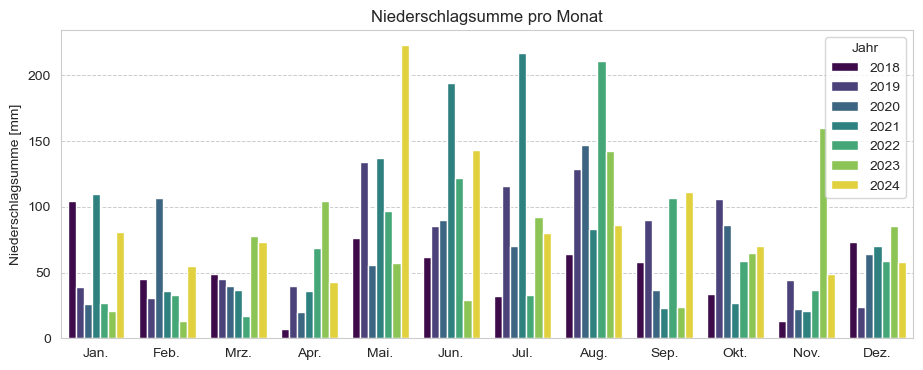

In [6]:
# Balkendiagramm erstellen
plt.figure(figsize=(11, 4))
sns.set_style("whitegrid")

# Farbpalette definieren
#farben = ['cornflowerblue', 'darkred', 'green', 'yellow', "#084594"]

# Barplot mit Farbunterscheidung nach Jahr
barplot = sns.barplot(data=dwd_RSK, x='Monat2', y='RSK', hue='Jahr', palette=color_list)

# Titel und Achsenbeschriftungen
barplot.set_title('Niederschlagsumme pro Monat')
barplot.set_ylabel('Niederschlagsumme [mm]')
barplot.set_xlabel(None)

# Gitterlinien anzeigen
barplot.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.legend(title='Jahr')
plt.show()

C:\Users\majaf\AppData\Local\Temp\ipykernel_28644\2286480534.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize="10")
C:\Users\majaf\AppData\Local\Temp\ipykernel_28644\2286480534.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_yticklabels(barplot.get_yticklabels(), fontsize="11")


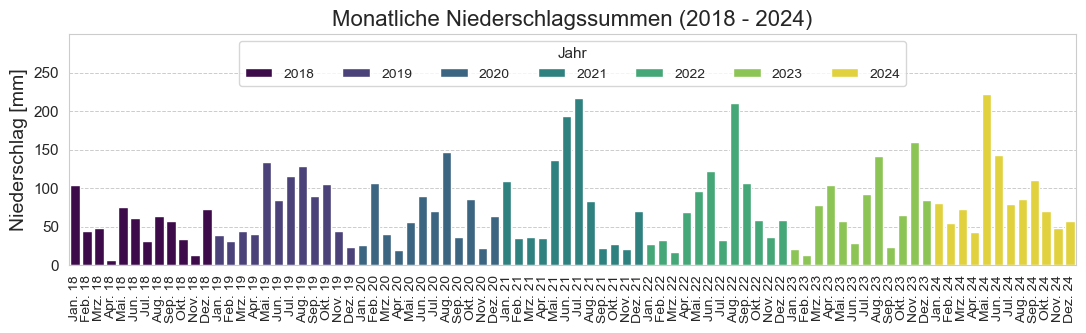

In [7]:
# Balkendiagramm erstellen
plt.figure(figsize=(13, 3))
sns.set_style("whitegrid")


# Barplot mit Farbunterscheidung nach Jahr
barplot = sns.barplot(data=dwd_RSK, x='Monat3', y='RSK', hue='Jahr', palette=color_list)

# x-Achsen-Labels drehen
# x-Achsen-Labels drehen und nach rechts verschieben
for label in barplot.get_xticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment('right')
    label.set_x(label.get_position()[0] + 5)  # Offset nach rechts

# Titel und Achsenbeschriftungen
# x-Achsen-Labels drehen und nach rechts verschieben
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize="10")
barplot.set_yticklabels(barplot.get_yticklabels(), fontsize="11")


# Gitterlinien anzeigen
barplot.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)


barplot.set_title(f'Monatliche Niederschlagssummen ({start_jahr} - {end_jahr})', fontsize="16")
barplot.set_xlabel(None)
barplot.set_ylabel('Niederschlag [mm]', fontsize="14")

plt.ylim(0, 300)
plt.legend(title='Jahr', title_fontsize = "11", fontsize="10", ncol=n_years, loc="upper center")
plt.show()

### 4) Lufttemperaturen

In [8]:
def check_leap_day(list_of_years):
    list_of_leap_years = []
    for year in list_of_years:
        if calendar.isleap(year):
            print(f"Achtung! {year} ist ein Schaltjahr.")
            list_of_leap_years.append(year)
    return list_of_leap_years 

dwd_TMK = dwd[["MESS_DATUM", "TMK"]].set_index("MESS_DATUM")[str(start_jahr):str(end_jahr)].resample("D").mean()
dwd_TMK["Jahr"] = dwd_TMK.index.year
dwd_TMK["Tag"] = dwd_TMK.index.dayofyear

list_of_leap_years = check_leap_day(dwd_TMK["Jahr"].unique())

for year in list_of_leap_years:
    dwd_TMK = dwd_TMK.drop(f'{year}-02-29')
    dwd_TMK.loc[str(year), 'Tag'] = dwd_TMK.loc[str(year), 'Tag'].where(dwd_TMK.loc[str(year), 'Tag'] <= 59, dwd_TMK.loc[str(year), 'Tag'] - 1)

dwd_TMK['TMK smooth'] = dwd_TMK['TMK'].rolling(window=35).mean()

dwd_TMK.head(20)

Achtung! 2020 ist ein Schaltjahr.
Achtung! 2024 ist ein Schaltjahr.


,TMK,Jahr,Tag,TMK smooth
MESS_DATUM,,,,
2018-01-01,6.7,2018,1,NaN
2018-01-02,4.9,2018,2,NaN
2018-01-03,6.4,2018,3,NaN
2018-01-04,7.7,2018,4,NaN
2018-01-05,9.7,2018,5,NaN
2018-01-06,7.1,2018,6,NaN
2018-01-07,4.3,2018,7,NaN
2018-01-08,3.9,2018,8,NaN
2018-01-09,4.7,2018,9,NaN


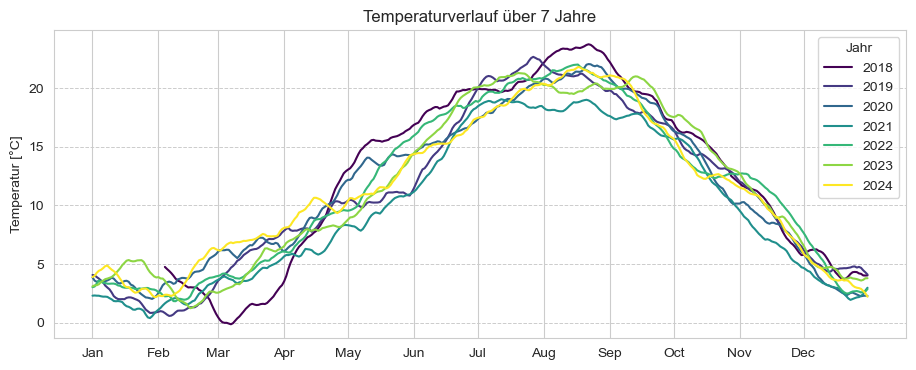

In [9]:
# Liniendiagramm erstellen
plt.figure(figsize=(11, 4))
sns.set_style("whitegrid")

# Lineplot mit Farbunterscheidung nach Jahr
lineplot = sns.lineplot(data=dwd_TMK, x='Tag', y='TMK smooth', hue='Jahr', palette=color_list)

# Titel und Achsenbeschriftungen
lineplot.set_title(f'Temperaturverlauf über {n_years} Jahre')
lineplot.set_xlabel('Monat')
lineplot.set_ylabel('Temperatur [°C]')

# Formatieren der x-Achse, um Abkürzungen der Monatsnamen anzuzeigen
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_ticks = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

lineplot.set_xlabel(None)

lineplot.set_xticks(month_ticks)
lineplot.set_xticklabels(month_names)
# Gitterlinien anzeigen
lineplot.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.legend(title='Jahr')
plt.show()

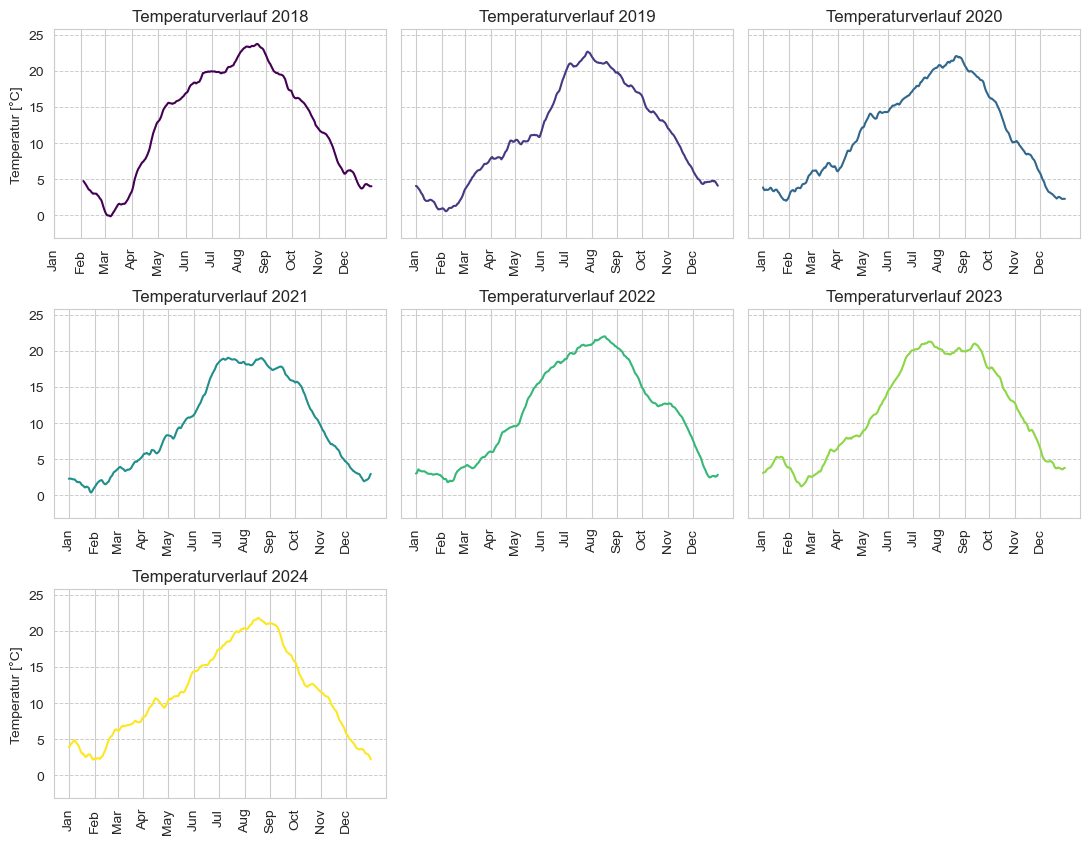

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Stil setzen
sns.set_style("whitegrid")

# Monatsnamen und zugehörige Tick-Positionen
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_ticks = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

# Einzigartige Jahre extrahieren und sortieren
years = sorted(dwd_TMK['Jahr'].unique())

# Gemeinsame y-Achsen-Grenzen ermitteln
y_min = dwd_TMK['TMK smooth'].min() - 3
y_max = dwd_TMK['TMK smooth'].max() + 2

color_dict = dict(zip(years, color_list))

# Anzahl der Zeilen berechnen (3 Spalten)
n_rows = math.ceil(n_years / 3)

# Subplots mit 3 Spalten erstellen
fig, axes = plt.subplots(n_rows, 3, figsize=(11, 3 * n_rows), sharex=False, sharey=True)

# Falls es nur eine Zeile gibt, in ein 2D-Array umwandeln
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Für jedes Jahr einen eigenen Plot erstellen
for i, year in enumerate(years):
    ax = axes[i]
    data_year = dwd_TMK[dwd_TMK['Jahr'] == year]
    sns.lineplot(data=data_year, x='Tag', y='TMK smooth', ax=ax, color=color_dict[year])
    
    ax.set_title(f'Temperaturverlauf {year}')
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(month_names, rotation=90)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(None)
    
    # Y-Achsenbeschriftung nur in der linken Spalte anzeigen
    if i % 2 == 0:
        ax.set_ylabel('Temperatur [°C]')
    else:
        ax.set_ylabel('')

# Leere Subplots entfernen, falls vorhanden (z.B. bei ungerader Anzahl von Jahren)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Gemeinsame x-Achsenbeschriftung hinzufügen
fig.text(0.5, 0.04, '', ha='center', va='center')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
